In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomResizedCrop

In [3]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform_gray=None, transform_color=None):
        """
        Args:
            root_dir (str): Directory containing 'gray' and 'color' subfolders.
            transform_gray (callable, optional): Transform to apply to grayscale images.
            transform_color (callable, optional): Transform to apply to color images.
        """
        self.gray_dir = os.path.join(root_dir, "gray")
        self.color_dir = os.path.join(root_dir, "color")
        
        # Load file names and ensure both have matching pairs
        self.gray_images = sorted(os.listdir(self.gray_dir))
        self.color_images = sorted(os.listdir(self.color_dir))
        assert len(self.gray_images) == len(self.color_images), "Mismatch in dataset sizes!"
        
        self.transform_gray = transform_gray
        self.transform_color = transform_color

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        # Load grayscale image
        gray_path = os.path.join(self.gray_dir, self.gray_images[idx])
        gray_image = Image.open(gray_path).convert("L")  # Ensure grayscale
        
        # Load color image
        color_path = os.path.join(self.color_dir, self.color_images[idx])
        color_image = Image.open(color_path).convert("RGB")  # Ensure RGB
        
        # Apply transforms if provided
        if self.transform_gray:
            gray_image = self.transform_gray(gray_image)
        if self.transform_color:
            color_image = self.transform_color(color_image)
        
        return gray_image, color_image



transform_gray = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation within 10 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize (mean, std) for grayscale
])

transform_color = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation within 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize (mean, std) for RGB
])


In [4]:
train_dataset = ColorizationDataset(
    root_dir="/kaggle/input/genai-dataset-project/train",
    transform_gray=transform_gray,
    transform_color=transform_color
)

test_dataset = ColorizationDataset(
    root_dir="/kaggle/input/genai-dataset-project/test",
    transform_gray=transform_gray,
    transform_color=transform_color
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Check a batch of data
for gray_batch, color_batch in train_loader:
    print("Gray batch shape:", gray_batch.shape)  # Should be [batch_size, 1, 256, 256]
    print("Color batch shape:", color_batch.shape)  # Should be [batch_size, 3, 256, 256]
    break

Gray batch shape: torch.Size([64, 1, 256, 256])
Color batch shape: torch.Size([64, 3, 256, 256])


In [5]:
!pip install segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.4 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=b84c80ce424ecbfd793bffac83c78d0c0dda36a47a586a0938824f3a8d6f9f77
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=266dd956f1c22db7fd6f40fc9d9bde9fc647af9d9a1380c8350e7998f8e9494c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [6]:
import torch
import torch.nn as nn
from segmentation_models_pytorch import Unet

# Load a pre-trained U-Net model
model = Unet(
    encoder_name="resnet34",        # Pre-trained encoder (ResNet-34)
    encoder_weights="imagenet",    # Use ImageNet weights
    in_channels=1,                 # Grayscale input
    classes=3                      # RGB output
)

# Print the model summary (optional)
print("Model loaded successfully")


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 147MB/s] 


Model loaded successfully


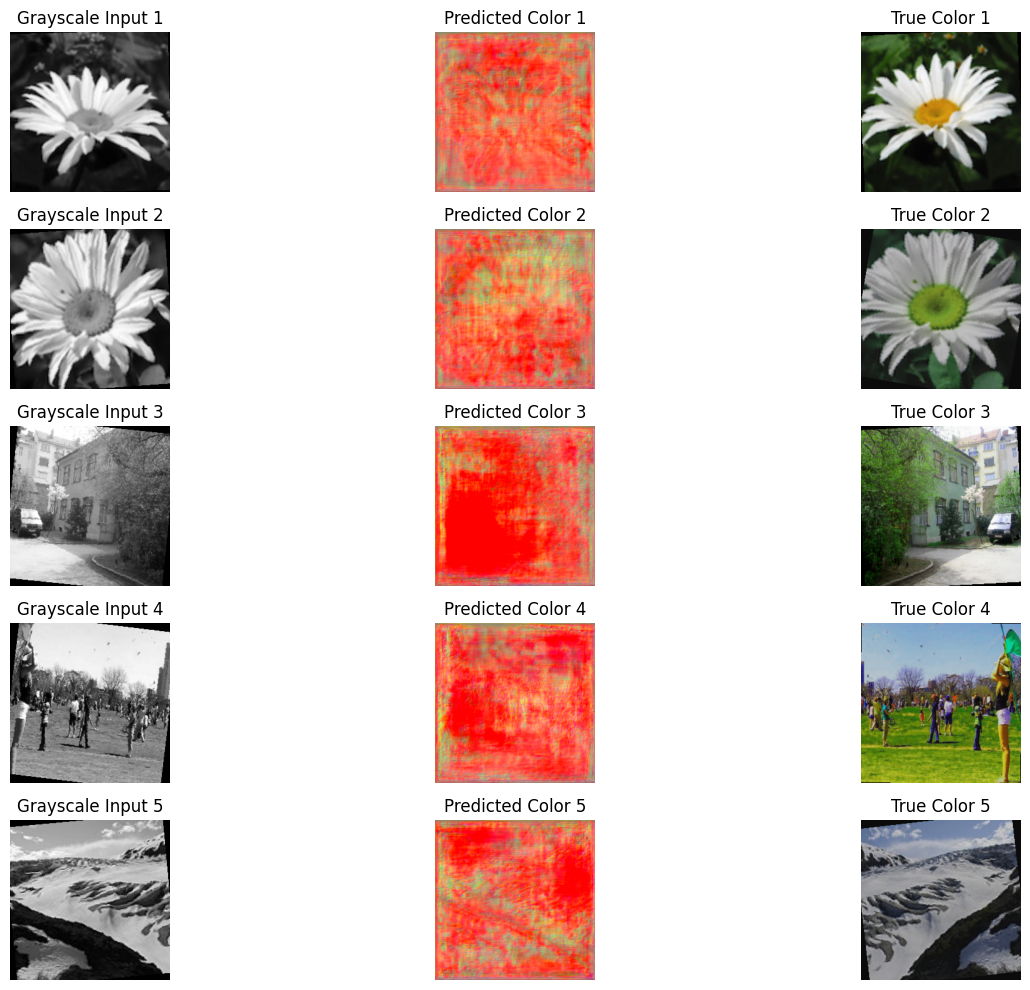

In [10]:
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device)
model.eval()

with torch.no_grad():
    for gray_batch, color_batch in test_loader:
        # Move inputs and model to the same device
        gray_batch = gray_batch.to(device)
        color_batch = color_batch.to(device)

        # Perform inference
        outputs = model(gray_batch)

        # Move tensors to CPU for visualization
        gray_images = gray_batch.cpu().numpy()
        predicted_colors = outputs.cpu().numpy()
        true_colors = color_batch.cpu().numpy()

        # Denormalize the outputs and true colors
        predicted_colors = (predicted_colors * 0.5) + 0.5  # Denormalize to [0, 1]
        true_colors = (true_colors * 0.5) + 0.5  # Denormalize to [0, 1]

        # Clip values to valid range
        predicted_colors = np.clip(predicted_colors, 0, 1)
        true_colors = np.clip(true_colors, 0, 1)

        # Display first 5 samples in the batch
        num_images = min(5, gray_images.shape[0])  # Ensure we don't exceed the batch size
        plt.figure(figsize=(15, 10))
        for i in range(num_images):
            # Grayscale Input
            plt.subplot(num_images, 3, i * 3 + 1)
            plt.title(f"Grayscale Input {i+1}")
            plt.imshow(gray_images[i][0], cmap="gray")  # Grayscale image
            plt.axis("off")
            
            # Predicted Color
            plt.subplot(num_images, 3, i * 3 + 2)
            plt.title(f"Predicted Color {i+1}")
            plt.imshow(predicted_colors[i].transpose(1, 2, 0))  # Predicted RGB image
            plt.axis("off")
            
            # True Color
            plt.subplot(num_images, 3, i * 3 + 3)
            plt.title(f"True Color {i+1}")
            plt.imshow(true_colors[i].transpose(1, 2, 0))  # Ground truth RGB image
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        break  # Only process one batch


In [11]:
pip install torchmetrics[image] lpips colormath torch-fidelity scikit-image

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.9 MB/s eta 0:00:00
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39407 sha256=0167a795cf879c15e5c988710b9dbeb8512db7844224f90bb96233f815af12de
  Stored in directory: /root/.cache/pip/wheels/ab/b3/4d/c0738759c25a1df01958068f162cf2a9dc3ab1da8b972cfcfc
Successfully built colormath
Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn.functional as F

def calculate_psnr(predicted, ground_truth):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between predicted and ground-truth images.
    Args:
        predicted (torch.Tensor): Predicted images, shape [B, C, H, W].
        ground_truth (torch.Tensor): Ground-truth images, shape [B, C, H, W].
    Returns:
        float: Average PSNR for the batch.
    """
    mse = F.mse_loss(predicted, ground_truth, reduction='none')  # Per-pixel MSE
    mse_per_image = mse.view(mse.size(0), -1).mean(dim=1)  # Average MSE per image
    psnr_per_image = 10 * torch.log10(1 / mse_per_image)  # Assuming pixel range [0, 1]
    return psnr_per_image.mean().item()

# Loop through the test loader to calculate average PSNR
def evaluate_psnr(model, test_loader, device):
    model.eval()
    total_psnr = 0.0
    num_batches = 0

    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)

            predicted = model(gray_batch)
            psnr = calculate_psnr(predicted, color_batch)
            total_psnr += psnr
            num_batches += 1

    return total_psnr / num_batches


In [13]:
from torchmetrics.image.fid import FrechetInceptionDistance

def evaluate_fid(model, test_loader, device):
    model.eval()
    fid = FrechetInceptionDistance(feature=2048).to(device)

    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)

            predicted = model(gray_batch)
            fid.update(preds=predicted, target=color_batch)

    return fid.compute().item()


In [15]:
import lpips

def evaluate_lpips(model, test_loader, device):
    model.eval()
    lpips_loss = lpips.LPIPS(net='alex').to(device)  # Use AlexNet features
    total_lpips = 0.0
    num_batches = 0

    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)

            predicted = model(gray_batch)
            batch_lpips = lpips_loss(predicted, color_batch)
            total_lpips += batch_lpips.mean().item()
            num_batches += 1

    return total_lpips / num_batches


In [16]:
from skimage.color import deltaE_ciede2000, rgb2lab

def rgb_to_lab(image):
    # Convert RGB to LAB for scikit-image
    image = image.permute(0, 2, 3, 1).cpu().numpy()  # Convert to HWC
    lab_images = [rgb2lab(img) for img in image]  # LAB conversion
    return lab_images

def evaluate_ciede2000(model, test_loader, device):
    model.eval()
    total_ciede2000 = 0.0
    num_pixels = 0

    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)

            predicted = model(gray_batch)
            predicted_lab = rgb_to_lab(predicted)
            true_lab = rgb_to_lab(color_batch)

            for pred_lab, true_lab in zip(predicted_lab, true_lab):
                diff = deltaE_ciede2000(pred_lab, true_lab)  # Calculate CIEDE2000
                total_ciede2000 += diff.sum()
                num_pixels += diff.size

    return total_ciede2000 / num_pixels


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate PSNR
psnr = evaluate_psnr(model, test_loader, device)
print(f"PSNR: {psnr:.2f} dB")


# Calculate LPIPS
lpips_score = evaluate_lpips(model, test_loader, device)
print(f"LPIPS: {lpips_score:.4f}")

# Calculate CIEDE2000
ciede2000 = evaluate_ciede2000(model, test_loader, device)
print(f"CIEDE2000: {ciede2000:.4f}")



PSNR: 0.46 dB
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 223MB/s]  


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/opt/conda/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

LPIPS: 0.8895
CIEDE2000: 60.6416
